We thought that finding the co-occurrences of words in the review with negative or positive words from the corpus would be a good way to find out exactly which parts of the purchased product make it good or bad. For example, in a hot sauce review, it would be helpful for manufacturers and consumers alike to understand if it's the flavor, packaging, or something else that make it popular or unpopular. We could use this both to be able to predict the number of stars that an Amazon review will recieve and to indicate to customers what the best parts of a product are.

In [3]:
import nltk
import pickle
import random

with open('training_dicts.txt', 'rb') as file:
    lemmedreviews = pickle.load(file)
    
#make lists for each class in training set 
one_star = lemmedreviews[1]
two_star = lemmedreviews[2]
three_star = lemmedreviews[3]
four_star = lemmedreviews[4]
five_star = lemmedreviews[5]

In [4]:
#find co-occurences 
from collections import Counter

def find_cooccs(lst):
    span = 3
    cooccs_stem_surface = Counter()

    for sentence in lst:
        for i,w in enumerate(sentence):
            #check all co-occurring words within a 3 word span 
            span_range = list(range(max(i- span, 0), i)) 
            span_range.extend(range(i+1, min(i + span + 1, len(sentence)))) 
            for cw in [sentence[idx] for idx in span_range]:
                if cw != w and (cw, w) not in cooccs_stem_surface:
                    cooccs_stem_surface[(w, cw)] += 1
    
    print(cooccs_stem_surface.most_common(10))
    return cooccs_stem_surface 

#apply to every class 
one_cooccs = find_cooccs(one_star)
two_cooccs = find_cooccs(two_star)
three_cooccs = find_cooccs(three_star)
four_cooccs = find_cooccs(four_star)
five_cooccs = find_cooccs(five_star)

[(('taste-NOUN', 'like-ADP'), 100), (('like-ADP', 'not-NEGATION'), 67), (('would-VERB', 'not-NEGATION'), 67), (('product-NOUN', 'not-NEGATION'), 61), (('not-NEGATION', 'taste-NOUN'), 51), (('not-NEGATION', 'even-ADV'), 43), (('not-NEGATION', 'buy-VERB'), 38), (('not-NEGATION', 'good-ADJ'), 35), (('get-VERB', 'not-NEGATION'), 31), (('coffee-NOUN', 'not-NEGATION'), 30)]
[(('taste-NOUN', 'like-ADP'), 72), (('not-NEGATION', 'like-ADP'), 51), (('not-NEGATION', 'taste-NOUN'), 46), (('would-VERB', 'not-NEGATION'), 41), (('coffee-NOUN', 'like-ADP'), 39), (('not-NEGATION', 'good-ADJ'), 38), (('not-NEGATION', 'product-NOUN'), 28), (('like-ADP', 'really-ADV'), 27), (('flavor-NOUN', 'not-NEGATION'), 25), (('not-NEGATION', 'much-ADJ'), 25)]
[(('taste-NOUN', 'like-ADP'), 87), (('would-VERB', 'not-NEGATION'), 79), (('not-NEGATION', 'taste-NOUN'), 71), (('not-NEGATION', 'like-ADP'), 65), (('coffee-NOUN', 'not-NEGATION'), 56), (('good-ADJ', 'not-NEGATION'), 53), (('really-ADV', 'not-NEGATION'), 51), ((

Find the most "polarized" combinations of words per class

In [5]:
#perform sentiment analysis
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn 
import operator 
import collections

#create mapping for proper sentiment analysis 
mapping = {'NOUN':wn.NOUN, "ADJ": wn.ADJ, 'VERB' : wn.VERB, "ADV": wn.ADV}

def find_vals(lst):
    #make synsets out of tuples
    list_cooccs = lst
    word1, word2 = "", ""
    positive_score, negative_score, positive_score2, negative_score2 = 0,0,0,0
    #dictionary to store tuples of co-occurences and their positivity 
    wordvals = {}

    #give items new mapping for use with senti_synsets
    for tup in list_cooccs:
        #get individual words out of tuple
        w1 = tup[0].split("-")
        w2 = tup[1].split("-")
    
        #check if first word in tuple is contained within mapping
        if w1[1] in mapping.keys() and mapping[w1[1]] == 'a':
            #extract part of speech
            one_pos = mapping[w1[1]]
            #extract the word itself 
            word1 = w1[0]
        
            #test that synsets exist 
            if len(list(swn.senti_synsets(word1, pos = one_pos))) > 0:
                scores = swn.senti_synset(word1 + "."+ one_pos + ".01")
                #calculate positive and negative scores for word 1 
                positive_score = scores.pos_score()
                negative_score = scores.neg_score()
            
        #repeat for second word in tuple         
        if w2[1] in mapping.keys() and mapping[w2[1]] == 'n':
            #extract part of speech 
            two_pos = mapping[w2[1]]
            word2 = w2[0]
        
            if len(list(swn.senti_synsets(word2, pos = two_pos))) > 0:
                scores2 = swn.senti_synset(word2 + "."+ two_pos + ".01")
                #calculate positive and negative scores for word 1 
                positive_score2 = scores2.pos_score()
                negative_score2 = scores2.neg_score() 
            
        #store tuples and positivity values in a dictionary
        tupl = (word1, word2)
        wordvals[tupl] = (positive_score + negative_score + positive_score2 + negative_score2)

    #sort the dictionary of positive and negative values from largest to smallest 
    sorted_wordvals = list(reversed(sorted(wordvals.items(), key=operator.itemgetter(1))))
    #sorted_dict = collections.OrderedDict(reversed(sorted_wordvals))
    return sorted_wordvals

one_vals = find_vals(one_cooccs)
two_vals = find_vals(two_cooccs)
three_vals = find_vals(three_cooccs)
four_vals = find_vals(four_cooccs)
five_vals = find_vals(five_cooccs)


In [6]:
print(one_vals[10:20])
print(two_vals[10:20])
print(three_vals[10:20])
print(four_vals[10:20])
print(five_vals[10:20])

[(('hard', 'hink'), 1.625), (('hard', 'bad'), 1.625), (('negative', 'boil'), 1.625), (('negative', 'cheap'), 1.625), (('pathetic', 'disease'), 1.625), (('pathetic', 'celiac'), 1.625), (('pathetic', 'grandeur'), 1.625), (('safe', 'stuck'), 1.625), (('safe', 'regret'), 1.625), (('easy', 'disappointment'), 1.625)]
[(('negative', 'celiac'), 1.5), (('true', 'dark'), 1.5), (('artificial', 'bliss'), 1.5), (('poor', 'drawback'), 1.5), (('delicious', 'emergency'), 1.5), (('nice', 'health'), 1.5), (('weigh', 'asset'), 1.5), (('impressed', 'nothing'), 1.5), (('impressed', 'contain'), 1.5), (('good', 'pain'), 1.5)]
[(('fresh', 'pinch'), 1.5), (('attractive', 'problem'), 1.5), (('good', 'scent'), 1.5), (('good', 'disproportional'), 1.5), (('good', 'complaint'), 1.5), (('good', 'doesnt'), 1.5), (('good', 'pain'), 1.5), (('unnatural', 'adhd'), 1.5), (('healthy', 'compare'), 1.5), (('easy', 'kona'), 1.5)]
[(('fresh', 'emergency'), 1.75), (('concerned', 'cheap'), 1.625), (('concerned', 'complaint'), 1.

We're going to find the PLMI of the co-occurences per class to use as a feature for classification 

In [7]:
#plmi measure
from itertools import chain
from math import log


def ppmi(o_11, r_1, c_1, n):
    """
    Positive Pointwise Mutual Information (Church & Hanks, 1990)
    
    PMI is also available in NLTK:
    from nltk.metrics import BigramAssocMeasures
    print BigramAssocMeasures.pmi(8, (15828, 4675), 14307668)
    """
    observed = o_11
    expected = (r_1*c_1)/n 
    res = log(observed/expected,2)
    return max(0, res)

def plmi(o_11, r_1, c_1, n):
    """
    Positive Local Mutual Information, useful for leveraging the 
    low-frequency bias of the PPMI
    """
    res = o_11 * ppmi(o_11, r_1, c_1, n)
    return res

def find_plmi(cooccs_dict, lst):
    N = len(cooccs_dict.values())
    plmis_lem_surface = Counter()
    lem_frequencies = Counter(chain(*lst))

    print(lem_frequencies)
    for k,v in cooccs_dict.items():
        plmis_lem_surface[k] = plmi(v, lem_frequencies[k[0]], lem_frequencies[k[1]], N)

    print(plmis_lem_surface.most_common(10))
    return plmis_lem_surface

In [8]:
one_plmi = find_plmi(one_cooccs, one_star)
#two_plmi =  find_plmi(two_cooccs, two_star)
#three_plmi = find_plmi(three_cooccs, three_star)
#four_plmi = find_plmi(four_cooccs, four_star)
#five_plmi = find_plmi(five_cooccs, five_star)

Counter({'not-NEGATION': 697, 'like-ADP': 373, 'taste-NOUN': 263, 'would-VERB': 253, 'product-NOUN': 246, 'get-VERB': 245, 'make-VERB': 223, 'one-NUM': 215, 'no-NEGATION': 192, 'coffee-NOUN': 186, 'even-ADV': 172, 'try-VERB': 169, 'food-NOUN': 166, 'go-VERB': 150, 'buy-VERB': 144, 'give-VERB': 132, 'good-ADJ': 130, 'know-VERB': 118, 'bad-ADJ': 116, 'flavor-NOUN': 116, 'say-VERB': 113, 'cup-NOUN': 112, 'time-NOUN': 112, 'bought-NOUN': 112, 'use-VERB': 108, 'amazon-NOUN': 108, 'really-ADV': 106, 'box-NOUN': 104, 'bag-NOUN': 99, 'well-ADV': 91, 'come-VERB': 90, 'order-VERB': 88, 'dog-NOUN': 87, 'chip-NOUN': 87, 'thought-NOUN': 85, 'review-NOUN': 84, 'much-ADJ': 83, 'receive-VERB': 81, 'first-ADV': 81, 'cat-NOUN': 81, 'eat-NOUN': 81, 'love-NOUN': 80, 'taste-VERB': 78, 'order-NOUN': 78, 'also-ADV': 78, 'chocolate-NOUN': 77, 'take-VERB': 75, 'two-NUM': 74, 'try-NOUN': 73, 'water-NOUN': 73, 'tea-NOUN': 72, 'never-ADV': 71, 'item-NOUN': 70, 'could-VERB': 70, 'way-NOUN': 68, 'think-NOUN': 68, '

We can also use the average positivity and negativity of each class to use as features as well.

In [9]:
#find average positivity + negativity for each word in each class 
def find_senti(lst):
    avg_review = []
    for sublist in lst:
        avg_positivity, avg_negativity, total_words = 0, 0, 0
        #find total num words in each class for calculating the average
        total_words = len(sublist)
        for word in sublist:
            #split item into individual word and lemma 
            trunc_word = word.split("-")
            #TODO: handle negation!! this is a band-aid  
            if trunc_word[1] not in mapping:
                continue
            #get the right part of speech from predefined mapping
            new_pos = mapping[trunc_word[1]]
            if len(list(swn.senti_synsets(trunc_word[0], pos = new_pos))) > 0:
                scores = swn.senti_synset(trunc_word[0] + "."+ new_pos + ".01")
                #find senti-wordnet's positivity and negativity rating for each word in each class  
                avg_positivity += scores.pos_score()
                avg_negativity += scores.neg_score() 
        avg_tupl = ((avg_positivity/total_words), (avg_negativity/total_words))
        avg_review.append(avg_tupl)
                
                

    return avg_review

In [10]:
one_senti = find_senti(one_star)
two_senti = find_senti(two_star)
three_senti = find_senti(three_star)
four_senti = find_senti(four_star)
five_senti = find_senti(five_star)


In [11]:
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
import seaborn as sns

# Lists of the average respectively positivity and negativity scores
# Deleted the zeroes from the negative scores otherwise there are 
# weird peaks
one_avg_pos = [avg_pos for avg_pos, avg_neg in one_senti] 
one_avg_neg = [avg_neg for avg_pos, avg_neg in one_senti] 
two_avg_pos = [avg_pos for avg_pos, avg_neg in two_senti] 
two_avg_neg = [avg_neg for avg_pos, avg_neg in two_senti] 
three_avg_pos = [avg_pos for avg_pos, avg_neg in three_senti] 
three_avg_neg = [avg_neg for avg_pos, avg_neg in three_senti] 
four_avg_pos = [avg_pos for avg_pos, avg_neg in four_senti] 
four_avg_neg = [avg_neg for avg_pos, avg_neg in four_senti] 
five_avg_pos = [avg_pos for avg_pos, avg_neg in five_senti] 
five_avg_neg = [avg_neg for avg_pos, avg_neg in five_senti] 


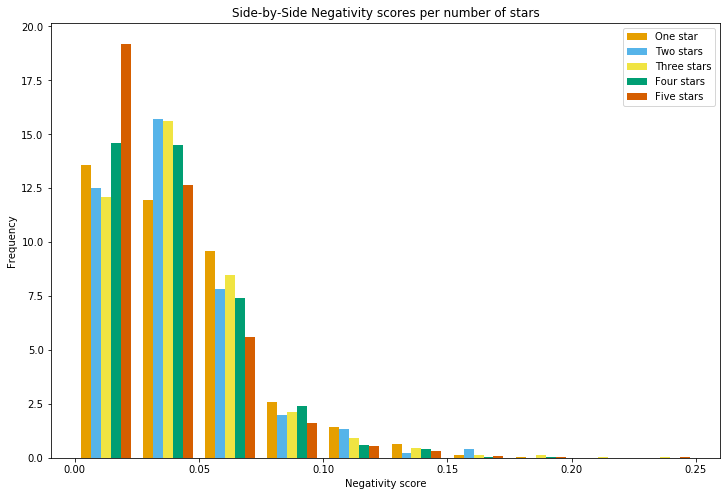

In [12]:
figsize(12,8)
#Assign colors to each score
colors = ['#E69F00', '#56B4E9', '#F0E442', '#009E73', '#D55E00']
names = ['One star', 'Two stars', 'Three stars', 'Four stars', 'Five stars']
plt.hist([one_avg_neg, two_avg_neg, three_avg_neg, four_avg_neg, five_avg_neg], 
         bins = 10, color=colors, label=names, density=True)

plt.legend()
plt.xlabel('Negativity score')
plt.ylabel('Frequency')
plt.title('Side-by-Side Negativity scores per number of stars')
plt.show()

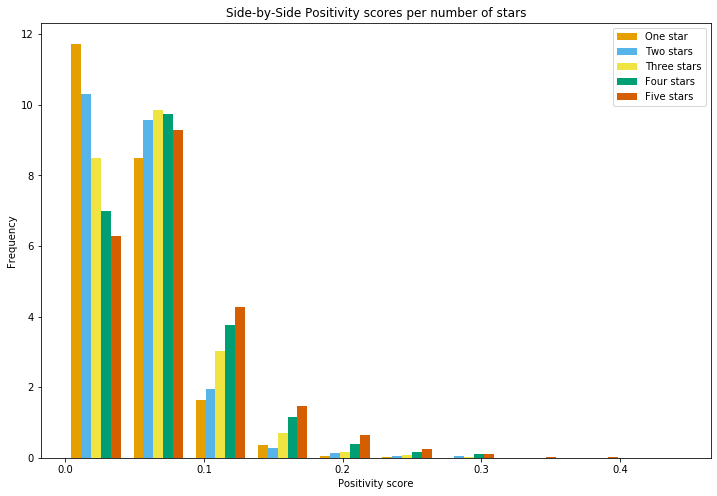

In [13]:

figsize(12,8)
colors = ['#E69F00', '#56B4E9', '#F0E442', '#009E73', '#D55E00']
names = ['One star', 'Two stars', 'Three stars', 'Four stars', 'Five stars']
plt.hist([one_avg_pos, two_avg_pos, three_avg_pos, four_avg_pos, five_avg_pos], 
         bins = 10, color=colors, label=names, density=True)

plt.legend()
plt.xlabel('Positivity score')
plt.ylabel('Frequency')
plt.title('Side-by-Side Positivity scores per number of stars')
plt.show()

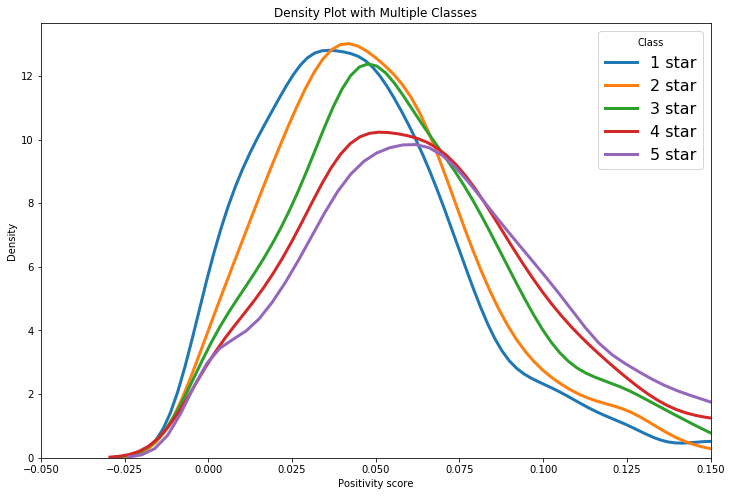

In [14]:
pos_list = [one_avg_pos, two_avg_pos, three_avg_pos, four_avg_pos, five_avg_pos]
fig, ax = plt.subplots()
for pos in pos_list:
    sns.distplot(pos, hist = False, kde = True, 
                 kde_kws = {'linewidth':3}, 
                 label = str(pos_list.index(pos)+1)+' star')
ax.set_xlim(-0.05,0.15)

    
plt.legend(prop={'size': 16}, title = 'Class')
plt.title('Density Plot with Multiple Classes'); 
plt.xlabel('Positivity score')
plt.ylabel('Density');
plt.show()

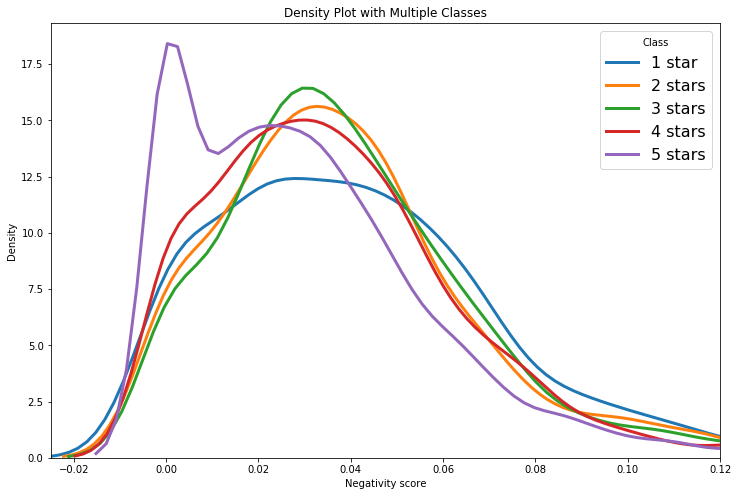

In [15]:
neg_list = [one_avg_neg, two_avg_neg, three_avg_neg, four_avg_neg, five_avg_neg]
fig, ax = plt.subplots()


def labels(index):
    num = index + 1
    if num > 1:
        return str(num) + ' stars'
    else: 
        return '1 star'

for neg in neg_list:
    sns.distplot(neg, hist = False, kde = True, 
                 kde_kws = {'linewidth':3}, 
                 label = labels(neg_list.index(neg)))

ax.set_xlim(-0.025,0.12)


plt.legend(prop={'size': 16}, title = 'Class')
plt.title('Density Plot with Multiple Classes')
plt.xlabel('Negativity score')
plt.ylabel('Density')
plt.show()

For this section, we want to find the noun that co-occurs with the most polar words in a review to be indicative of the best quality of a product. This is not a feature for our classifier, but rather something that would be interesting to a manufacturer or a user. It finds the nouns in a review and the words it co-occurs with in a 3-word span. It then finds the polarity of the words in the span and chooses the noun with the co-occurring words with the highest polarity. In this context, polarity is defined as the sum of a word's positivity and negativity scores. 

In [66]:
#TODO: Handle Negation 
def analyze_review(lst):
    span = 1
    impt_features = {}
    highest_polarity = 0
    for review in lst:
        for i,w in enumerate(review):
            w1, w2 = w.split("-") 
            if w2 != 'NOUN':
                continue   
            #check all co-occurring words within a 3 word span 
            span_range = list(range(max(i- span, 0), i)) 
            span_range.extend(range(i+1, min(i + span + 1, len(review))))
            for cw in [review[idx] for idx in span_range]:
                cw1, cw2 = cw.split("-")
                if cw2 in mapping:
                    #get the right part of speech from predefined mapping
                    new_pos = mapping[cw2]
                    if len(list(swn.senti_synsets(cw1, pos = new_pos))) > 0 and cw2 == "ADJ":
                        scores = swn.senti_synset(cw1 + "."+ new_pos + ".01")
                        #make polarity the sum of positivity and negativity
                        polarity = scores.pos_score() + scores.neg_score()
                        if polarity > highest_polarity:
                            highest_polarity = polarity
                            #set key equal to the string literal of the review, 
                            #val equal to the most important noun and its associated adjective
                            #impt_features[repr(review)] = (cw, w1)
                            impt_features[int(polarity)] = (cw, w1+"-"+w2)
       
                
                
    return impt_features 

In [67]:
one_properties = analyze_review(one_star)
two_properties = analyze_review(two_star)
three_properties = analyze_review(three_star)
four_properties = analyze_review(four_star)
five_properties = analyze_review(five_star)

In [69]:
#find the largest key (aka most polar item) in dictionary
print(one_properties[max(one_properties, key=one_properties.get)])


#track = {}
#for key,value in five_properties.items():
 ##      track[value]=0
    #else:
   #     track[value]+=1

#print(max(track,key=track.get))


('impressed-ADJ', 'cooky-NOUN')


In [ ]:
#TODO: plot the most common polar items 